In [1]:
from tqdm import tqdm
import numpy as np
from requests import get
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from typing import List, Dict
from pprint import pprint as pp
import datetime

In [122]:
def meta_url(datasetID: str,flavor: str = 'json') -> Dict: 
    meta_url: str = f"http://www.neracoos.org/erddap/info/{datasetID}/index.{flavor}"
    return get(meta_url).json() 
def data_url(datasetID: str, flavor: str = 'json') -> Dict:
    data_url: str = f"http://www.neracoos.org/erddap/tabledap/{datasetID}.{flavor}"
    return get(data_url).json() 
GOM_IDS = ["A01"]
def make_df(set_name,from_url=True):
    set_name = data_url(set_name)
    response = set_name['table']
    print(response['columnNames'])
    new_df = pd.DataFrame(response['rows'], columns = response['columnNames'])
    new_df['time'] = pd.to_datetime(new_df['time'])
    new_df = new_df.set_index('time')
    return new_df[new_df.columns[~new_df.columns.str.contains('_qc')]]

In [7]:
META_DATA: Dict = data_url('allDatasets')
meta_0: pd.DataFrame = pd.DataFrame(META_DATA['table']['rows'],columns=META_DATA['table']['columnNames'])

In [8]:
meta = meta_0.loc[meta_0['title'].str.contains('|'.join(GOM_IDS))].set_index('datasetID')

In [9]:
meta.columns

Index(['accessible', 'institution', 'dataStructure', 'cdm_data_type', 'class',
       'title', 'minLongitude', 'maxLongitude', 'longitudeSpacing',
       'minLatitude', 'maxLatitude', 'latitudeSpacing', 'minAltitude',
       'maxAltitude', 'minTime', 'maxTime', 'timeSpacing', 'griddap', 'subset',
       'tabledap', 'MakeAGraph', 'sos', 'wcs', 'wms', 'files', 'fgdc',
       'iso19115', 'metadata', 'sourceUrl', 'infoUrl', 'rss', 'email',
       'testOutOfDate', 'outOfDate', 'summary'],
      dtype='object')

In [10]:
active_datasets = list(meta[meta['maxTime'].str.contains('2020')].index)
active_datasets

['A01_aanderaa_o2_all',
 'A01_accelerometer_all',
 'A01_waves_mstrain_all',
 'A01_met_all',
 'A01_optics_s_all',
 'A01_optode_all',
 'A01_doppler_rt',
 'A01_sbe16_disox_all',
 'A01_sbe37_all']

In [123]:
df = make_df('A01_optics_s_all')
sal_temp = make_df('A01_sbe37_all')[['salinity','temperature','depth']]
sal_df = make_df('A01_sbe16_disox_all')

['station', 'mooring_site_desc', 'time', 'chlorophyll', 'chlorophyll_qc', 'turbidity', 'turbidity_qc', 'longitude', 'latitude', 'depth']
['station', 'time', 'mooring_site_desc', 'conductivity', 'conductivity_qc', 'temperature', 'temperature_qc', 'salinity', 'salinity_qc', 'sigma_t', 'sigma_t_qc', 'longitude', 'latitude', 'depth']
['station', 'time', 'mooring_site_desc', 'dissolved_oxygen', 'dissolved_oxygen_qc', 'oxygen_saturation', 'oxygen_saturation_qc', 'percent_oxygen_saturation', 'percent_oxygen_saturation_qc', 'conductivity', 'conductivity_qc', 'temperature', 'temperature_qc', 'salinity', 'salinity_qc', 'sigma_t', 'sigma_t_qc', 'longitude', 'latitude', 'depth']


In [119]:
big_df = df.join(sal_temp,rsuffix = '1',how='outer')

In [136]:
big_df.index

DatetimeIndex(['2001-07-10 04:00:01+00:00', '2001-07-10 04:34:00+00:00',
               '2001-07-10 05:00:01+00:00', '2001-07-10 05:34:00+00:00',
               '2001-07-10 06:00:01+00:00', '2001-07-10 06:34:00+00:00',
               '2001-07-10 07:00:01+00:00', '2001-07-10 07:34:00+00:00',
               '2001-07-10 08:00:01+00:00', '2001-07-10 08:34:00+00:00',
               ...
               '2020-10-19 17:00:00+00:00', '2020-10-19 17:30:00+00:00',
               '2020-10-19 18:00:00+00:00', '2020-10-19 18:00:00+00:00',
               '2020-10-19 18:30:00+00:00', '2020-10-19 19:00:00+00:00',
               '2020-10-19 19:00:00+00:00', '2020-10-19 19:30:00+00:00',
               '2020-10-19 20:00:00+00:00', '2020-10-19 20:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='time', length=525020, freq=None)

In [171]:
day_df = big_df.resample("D").median()
day_df['curr'] = currents['current_speed'].resample("D").median()
day_df['oxy'] = currents['percent_oxygen_saturation'].resample("D").median()/10

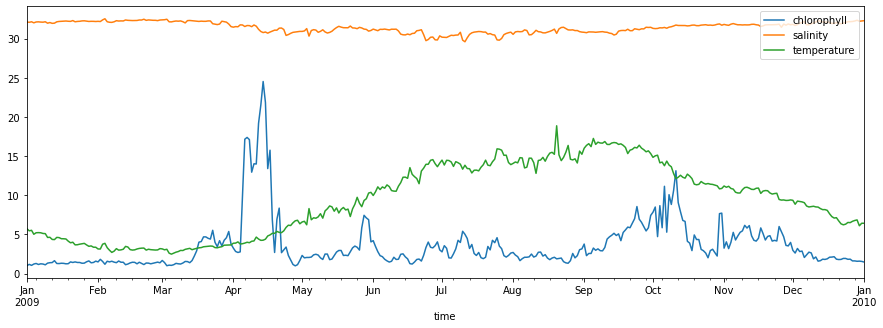

In [184]:
dr = ['2009-01-01','2010-01-01']
fig, ax = plt.subplots(1,1,figsize=(15, 5))
day_df[['chlorophyll','salinity']].loc[dr[0]:dr[1]].resample("D").mean().plot(style="-",ax=ax)
day_df[['temperature']].loc[dr[0]:dr[1]].resample("D").mean().plot(style="-",ax=ax)
plt.legend(loc = 'upper right')

In [127]:
currents = make_df('A01_aanderaa_o2_all')

['station', 'mooring_site_desc', 'water_depth', 'time', 'longitude', 'latitude', 'depth', 'current_speed', 'current_speed_qc', 'current_direction', 'current_direction_qc', 'current_u', 'current_u_qc', 'current_v', 'current_v_qc', 'temperature', 'temperature_qc', 'dissolved_oxygen', 'dissolved_oxygen_qc', 'percent_oxygen_saturation', 'percent_oxygen_saturation_qc', 'time_created', 'time_modified']


In [130]:
currents['current_speed']

time
2001-07-10 03:00:00+00:00    24.0506
2001-07-10 04:00:00+00:00    17.8913
2001-07-10 05:00:00+00:00     9.6789
2001-07-10 06:00:00+00:00     3.5196
2001-07-10 07:00:00+00:00    12.6119
                              ...   
2020-10-19 17:00:00+00:00    16.8915
2020-10-19 18:00:00+00:00    16.6733
2020-10-19 19:00:00+00:00    16.7884
2020-10-19 20:00:00+00:00    17.3363
2020-10-19 21:00:00+00:00    15.3853
Name: current_speed, Length: 146167, dtype: float64

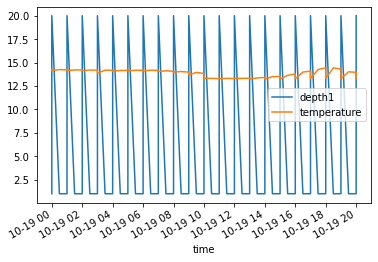

In [78]:
big_df[['depth1','temperature']].loc['2020-10-19'].plot()
big_df['temp_20'] = 

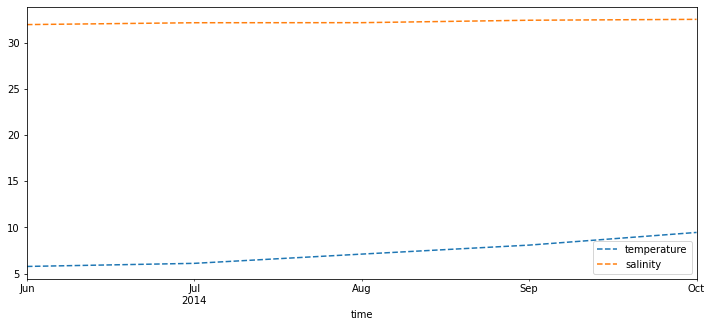

In [93]:
dr = ['2014-01-01','2018-08-01']
sal_df[['temperature','salinity']].loc[dr[0]:dr[1]].resample("M").mean().plot(style="--", figsize=(12, 5));

In [101]:
sal_df['2014']

,station,mooring_site_desc,dissolved_oxygen,oxygen_saturation,percent_oxygen_saturation,conductivity,temperature,salinity,sigma_t,longitude,latitude,depth
time,,,,,,,,,,,,
2014-06-04 01:00:00+00:00,A01,Massachusetts Bay,6.310979,7.221090,87.396484,30.940,5.034,32.039690,25.32537,-70.5655,42.5232,50.0
2014-06-04 02:00:00+00:00,A01,Massachusetts Bay,6.291374,7.231754,86.996506,30.894,4.971,32.047530,25.33845,-70.5655,42.5232,50.0
2014-06-04 03:00:00+00:00,A01,Massachusetts Bay,6.265983,7.228348,86.686240,30.935,4.980,32.085915,25.36788,-70.5655,42.5232,50.0
2014-06-04 04:00:00+00:00,A01,Massachusetts Bay,6.249856,7.219080,86.574135,30.984,5.031,32.092990,25.36792,-70.5655,42.5232,50.0
2014-06-04 05:00:00+00:00,A01,Massachusetts Bay,6.296538,7.209544,87.336150,31.036,5.083,32.102493,25.36974,-70.5655,42.5232,50.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2014-10-25 13:00:00+00:00,A01,Massachusetts Bay,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-70.5655,42.5232,50.0
2014-10-25 14:00:00+00:00,A01,Massachusetts Bay,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-70.5655,42.5232,50.0
2014-10-25 15:00:00+00:00,A01,Massachusetts Bay,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-70.5655,42.5232,50.0


In [235]:
final_df.resample("W").mean().plot(style="--", figsize=(12, 5));

TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'RangeIndex'

In [234]:
final_df

,den_20,den_50,sal_1,sal_20,sal_50,temp,time
0,NaN,NaN,NaN,NaN,NaN,NaN,2009-01-01 00:00:00+00:00
1,NaN,NaN,NaN,NaN,NaN,NaN,2009-01-01 00:03:00+00:00
2,NaN,NaN,NaN,NaN,NaN,NaN,2009-01-01 00:06:00+00:00
3,NaN,NaN,NaN,NaN,NaN,NaN,2009-01-01 00:09:00+00:00
4,NaN,NaN,NaN,NaN,NaN,NaN,2009-01-01 00:10:00+00:00
...,...,...,...,...,...,...,...
82012,NaN,NaN,NaN,NaN,NaN,NaN,2009-11-30 23:20:00+00:00
82013,NaN,NaN,NaN,NaN,NaN,NaN,2009-11-30 23:30:00+00:00
82014,NaN,NaN,NaN,NaN,NaN,NaN,2009-11-30 23:40:00+00:00
82015,NaN,NaN,NaN,NaN,NaN,NaN,2009-11-30 23:50:00+00:00


In [237]:
final_df = pd.DataFrame(raw_data,columns = ['den_20','den_50','sal_1','sal_20','sal_50','temp'])
final_df['time'] = pd.to_datetime(raw_data['Time-UTC'])
final_df = final_df.set_index('time')

In [230]:
raw_data = pd.read_csv('/Users/zoeshleifer/bouy_data.csv')
chloro_daily = raw_data.tail(335)[['A011m-Hourly-Density_kg/m^3','Time-UTC']]
raw_data = raw_data[:-335]

/Users/zoeshleifer/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


  
  A01_aanderaa_hist  
  
  'station', 'time', 'mooring_site_desc', 'current_speed', 'current_speed_qc', 'current_direction', 'current_direction_qc', 'temperature', 'temperature_qc', 'longitude', 'latitude', 'depth'
  
  A01_aanderaa_o2_all  
  
  'station', 'mooring_site_desc', 'water_depth', 'time', 'longitude', 'latitude', 'depth', 'current_speed', 'current_speed_qc', 'current_direction', 'current_direction_qc', 'current_u', 'current_u_qc', 'current_v', 'current_v_qc', 'temperature', 'temperature_qc', 'dissolved_oxygen', 'dissolved_oxygen_qc', 'percent_oxygen_saturation', 'percent_oxygen_saturation_qc', 'time_created', 'time_modified'
  
  A01_accelerometer_all  
  
  'station', 'time', 'mooring_site_desc', 'significant_wave_height', 'significant_wave_height_qc', 'dominant_wave_period', 'dominant_wave_period_qc', 'longitude', 'latitude', 'depth'
  
  A01_waves_mstrain_all 
  
  'station', 'time', 'mooring_site_desc', 'water_depth', 'index', 'significant_wave_height_3', 'significant_wave_height_3_qc', 'maximum_wave_height_3', 'maximum_wave_height_3_qc', 'dominant_wave_period_3', 'dominant_wave_period_3_qc', 'mean_wave_direction_3', 'mean_wave_direction_3_qc', 'mean_wave_direction_spread_3', 'mean_wave_direction_spread_3_qc', 'principal_wave_direction_3', 'principal_wave_direction_3_qc', 'principal_wave_direction_spread_3', 'principal_wave_direction_spread_3_qc', 'swell_wave_height_3', 'swell_wave_height_3_qc', 'swell_wave_period_3', 'swell_wave_period_3_qc', 'wind_wave_height_3', 'wind_wave_height_3_qc', 'wind_wave_period_3', 'wind_wave_period_3_qc', 'swell_and_wind_wave_separation_frequency_3', 'swell_and_wind_wave_separation_frequency_3_qc', 'wave_steepness_3', 'wave_steepness_3_qc', 'offset_time', 'time_created', 'time_modified', 'longitude', 'latitude', 'depth'
  
  A01_met_all  
  
  'station', 'time', 'mooring_site_desc', 'air_temperature', 'air_temperature_qc', 'barometric_pressure', 'barometric_pressure_qc', 'wind_gust', 'wind_gust_qc', 'wind_speed', 'wind_speed_qc', 'wind_direction', 'wind_direction_qc', 'visibility', 'visibility_qc', 'longitude', 'latitude', 'depth'
  
  A01_optics_s_all  
  
  'station', 'mooring_site_desc', 'time',_A01_aanderaa_hist
  
  'station', 'time', 'mooring_site_desc', 'current_speed', 'current_speed_qc', 'current_direction', 'current_direction_qc', 'temperature', 'temperature_qc', 'longitude', 'latitude', 'depth'
  
  A01_aanderaa_o2_all  
  
  'station', 'mooring_site_desc', 'water_depth', 'time', 'longitude', 'latitude', 'depth', 'current_speed', 'current_speed_qc', 'current_direction', 'current_direction_qc', 'current_u', 'current_u_qc', 'current_v', 'current_v_qc', 'temperature', 'temperature_qc', 'dissolved_oxygen', 'dissolved_oxygen_qc', 'percent_oxygen_saturation', 'percent_oxygen_saturation_qc', 'time_created', 'time_modified'
  
  A01_accelerometer_all  
  
  'station', 'time', 'mooring_site_desc', 'significant_wave_height', 'significant_wave_height_qc', 'dominant_wave_period', 'dominant_wave_period_qc', 'longitude', 'latitude', 'depth'
  
  A01_waves_mstrain_all  
  
  'station', 'time', 'mooring_site_desc', 'water_depth', 'index', 'significant_wave_height_3', 'significant_wave_height_3_qc', 'maximum_wave_height_3', 'maximum_wave_height_3_qc', 'dominant_wave_period_3', 'dominant_wave_period_3_qc', 'mean_wave_direction_3', 'mean_wave_direction_3_qc', 'mean_wave_direction_spread_3', 'mean_wave_direction_spread_3_qc', 'principal_wave_direction_3', 'principal_wave_direction_3_qc', 'principal_wave_direction_spread_3', 'principal_wave_direction_spread_3_qc', 'swell_wave_height_3', 'swell_wave_height_3_qc', 'swell_wave_period_3', 'swell_wave_period_3_qc', 'wind_wave_height_3', 'wind_wave_height_3_qc', 'wind_wave_period_3', 'wind_wave_period_3_qc', 'swell_and_wind_wave_separation_frequency_3', 'swell_and_wind_wave_separation_frequency_3_qc', 'wave_steepness_3', 'wave_steepness_3_qc', 'offset_time', 'time_created', 'time_modified', 'longitude', 'latitude', 'depth'
  
  A01_met_all  
  
  'station', 'time', 'mooring_site_desc', 'air_temperature', 'air_temperature_qc', 'barometric_pressure', 'barometric_pressure_qc', 'wind_gust', 'wind_gust_qc', 'wind_speed', 'wind_speed_qc', 'wind_direction', 'wind_direction_qc', 'visibility', 'visibility_qc', 'longitude', 'latitude', 'depth'
  
  A01_optics_s_all  
  
  'station', 'mooring_site_desc', 'time', _'chlorophyll'_, 'chlorophyll_qc', 'turbidity', 'turbidity_qc', 'longitude', 'latitude', 'depth'
  
  A01_optode_all  
  
  'station', 'time', 'mooring_site_desc', 'dissolved_oxygen', 'dissolved_oxygen_qc', 'oxygen_saturation', 'oxygen_saturation_qc', 'percent_oxygen_saturation', 'percent_oxygen_saturation_qc', 'temperature', 'temperature_qc', 'time_created', 'time_modified', 'longitude', 'latitude', 'depth'
  
  A01_doppler_rt  
  
  'station', 'mooring_site_desc', 'water_depth', 'time', 'longitude', 'latitude', 'depth', 'offset_time', 'current_u', 'current_u_qc', 'current_v', 'current_v_qc'
  
  A01_sbe16_trans_all  
  
  'station', 'time', 'mooring_site_desc', 'water_depth', 'transmissivity_voltage', 'transmissivity_voltage_qc', 'transmissivity', 'transmissivity_qc', 'attenuation', 'attenuation_qc', 'conductivity', 'conductivity_qc', 'temperature', 'temperature_qc', 'salinity', 'salinity_qc', 'sigma_t', 'sigma_t_qc', 'time_created', 'time_modified', 'longitude', 'latitude', 'depth'
  
  A01_sbe16_disox_all  
  
  'station', 'time', 'mooring_site_desc', 'dissolved_oxygen', 'dissolved_oxygen_qc', 'oxygen_saturation', 'oxygen_saturation_qc', 'percent_oxygen_saturation', 'percent_oxygen_saturation_qc', 'conductivity', 'conductivity_qc', 'temperature', 'temperature_qc', 'salinity', 'salinity_qc', 'sigma_t', 'sigma_t_qc', 'longitude', 'latitude', 'depth'
  
  A01_sbe37_all  
  
  'station', 'time', 'mooring_site_desc', 'conductivity', 'conductivity_qc', 'temperature', 'temperature_qc', 'salinity', 'salinity_qc', 'sigma_t', 'sigma_t_qc', 'longitude', 'latitude', 'depth'_, 'chlorophyll_qc', 'turbidity', 'turbidity_qc', 'longitude', 'latitude', 'depth'
  
  A01_optode_all  
  
  'station', 'time', 'mooring_site_desc', 'dissolved_oxygen', 'dissolved_oxygen_qc', 'oxygen_saturation', 'oxygen_saturation_qc', 'percent_oxygen_saturation', 'percent_oxygen_saturation_qc', 'temperature', 'temperature_qc', 'time_created', 'time_modified', 'longitude', 'latitude', 'depth'
  
  A01_doppler_rt  
  
  'station', 'mooring_site_desc', 'water_depth', 'time', 'longitude', 'latitude', 'depth', 'offset_time', 'current_u', 'current_u_qc', 'current_v', 'current_v_qc'
  
  A01_sbe16_trans_all  
  
  'station', 'time', 'mooring_site_desc', 'water_depth', 'transmissivity_voltage', 'transmissivity_voltage_qc', 'transmissivity', 'transmissivity_qc', 'attenuation', 'attenuation_qc', 'conductivity', 'conductivity_qc', 'temperature', 'temperature_qc', 'salinity', 'salinity_qc', 'sigma_t', 'sigma_t_qc', 'time_created', 'time_modified', 'longitude', 'latitude', 'depth'
  
  A01_sbe16_disox_all  
  
  'station', 'time', 'mooring_site_desc', 'dissolved_oxygen', 'dissolved_oxygen_qc', 'oxygen_saturation', 'oxygen_saturation_qc', 'percent_oxygen_saturation', 'percent_oxygen_saturation_qc', 'conductivity', 'conductivity_qc', 'temperature', 'temperature_qc', 'salinity', 'salinity_qc', 'sigma_t', 'sigma_t_qc', 'longitude', 'latitude', 'depth'
  
  A01_sbe37_all  
  
  'station', 'time', 'mooring_site_desc', 'conductivity', 'conductivity_qc', 'temperature', 'temperature_qc', 'salinity', 'salinity_qc', 'sigma_t', 'sigma_t_qc', 'longitude', 'latitude', 'depth'